This notebook loads the CalMS21 Task 1 dataset (which has data as keypoints of the 2 mice for each time point) and converts it to "syllables" or behavioural states (by training the keypoint-MoSeq model)

--

Method:

We use the keypoint-MoSeq model as explained in this paper: https://www.nature.com/articles/s41592-024-02318-2

They have documentation and code along with it in this link: https://keypoint-moseq.readthedocs.io/en/latest/modeling.html

This notebook downloads the CalMS21 Task 1 dataset, transforms it so that it can be given as input to the kepoint-MoSeq code and creates a config file for the same. After that, it mainly follows along the code given in the above documnetation to finally get the "syllables" and get a matrix mapping each timepoint to a syllable (as well as: centroid and heading, and latent states) instead of keypoints of each of the mice.

_

Note: Ths code follows the code in the documentation linked above. So please go through that if there is any confusion as to what is going on in the code. They explain each step pretty well

Further information and documentation on MoSeq (Mouse Sequence) can be found in the following link which also has the research papers associated with them linked there: https://dattalab.github.io/moseq2-website/index.html#about

### Installing keypoint MoSeq
*and other import statements*

In [2]:
# This takes about 10-15 mins
! apt update && apt install cuda-11-8
! pip install tensorflow==2.12.0
! pip install --upgrade "jax[cuda]==0.3.22" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
! pip install keypoint-moseq

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Ign:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:11 https://r2u.stat.illinois.edu/ubuntu jammy Release
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
52 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as 

In [4]:
# So that the outputs can be saved on drive
import os
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [ ]:
import keypoint_moseq as kpms
import json
import numpy as np
import pandas as pd

# Project setup
Create a new project directory with a keypoint-MoSeq `config.yml` file.

In [5]:
# location where you want to save the outputs
# PS: keypoint-MoSeq has a bunch of outputs which get automatically saved here

project_dir = '/content/drive/MyDrive/NMA_Project_v1/'
config = lambda: kpms.load_config(project_dir)

In [ ]:
# You can save the video files of each assay here if you want to visualize the outputs later on. It is not mandatory
data_dir = "/content/drive/MyDrive/NMA_Project_V1_Data_dir"

### Option 3: Manual setup

*We have to go with manual set up because they have built in functions only for some type of data formats*

In [ ]:
bodyparts=['nose', 'left ear', 'right ear', 'neck', 'left hip', 'right hip', 'tail base']

skeleton=[
     ['tail base', 'left hip'],
     ['tail base', 'right hip'],
     ['right hip', 'neck'],
     ['left hip', 'neck'],
     ['left ear', 'neck'],
     ['right ear', 'neck'],
     ['left ear', 'nose'],
     ['right ear', 'nose']]

video_dir = os.path.join(data_dir, 'videos')

kpms.setup_project(
     project_dir,
     video_dir=video_dir,
     bodyparts=bodyparts,
     skeleton=skeleton)

#### Edit the config file

The config can be edited in a text editor or using the function `kpms.update_config`, as shown below. In general, the following parameters should be specified for each project:

- `bodyparts` (name of each keypoint; automatically imported from SLEAP/DeepLabCut)
- `use_bodyparts` (subset of bodyparts to use for modeling, set to all bodyparts by default; for mice we recommend excluding the tail)
- `anterior_bodyparts` and `posterior_bodyparts` (used for rotational alignment)
- `video_dir` (directory with videos of each experiment)

In [ ]:
kpms.update_config(
    project_dir,
    video_dir=os.path.join(data_dir, 'videos'),
    anterior_bodyparts=['nose'],
    posterior_bodyparts=['tail base'],
    use_bodyparts=['nose', 'left ear', 'right ear', 'neck', 'left hip', 'right hip', 'tail base']
    )

## Download the CalMS21 Dataset

Following the code given by Neuromatch to download the Task 1 dataset: https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/behavior/Loading_CalMS21_data.ipynb

In [ ]:
# @title Download and unzip the data
import os, requests, zipfile

fname = 'task1_classic_classification.zip'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/task1_classic_classification.zip?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)
else:
  print('Data have already been downloaded!!!')

if not os.path.exists('task1_classic_classification'):
  # Unzip the file
  with zipfile.ZipFile(fname, 'r') as zip_ref:
    zip_ref.extractall('.')


# Download the script
fname = 'calms21_convert_to_npy.py'
url = "https://data.caltech.edu/records/s0vdx-0k302/files/calms21_convert_to_npy.py?download=1"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
!python calms21_convert_to_npy.py  --input_directory '.' --output_directory '.'

Saving ./calms21_task1_test
Saving ./calms21_task1_train


### Load the CalMS21 data

The following loader function can be used to unpack the `.npy` files containing your train and test sets.

In [ ]:
def load_task1_data(data_path):
  """
  Load data for task 1:
      The vocaubulary tells you how to map behavior names to class ids;
      it is the same for all sequences in this dataset.
  """
  data_dict = np.load(data_path, allow_pickle=True).item()
  dataset = data_dict['annotator-id_0']
  # Get any sequence key.
  sequence_id = list(data_dict['annotator-id_0'].keys())[0]
  vocabulary = data_dict['annotator-id_0'][sequence_id]['metadata']['vocab']
  return dataset, vocabulary

In [ ]:
training_data, vocab = load_task1_data('./calms21_task1_train.npy')
test_data, _ = load_task1_data('./calms21_task1_test.npy')

## Reshaping for Keypoint-Moseq input

Keypoint-moseq model requires 3 inputs: Coordinates, confidences, bodyparts

### Testing/Experimenting

*this is just rough work.
You can ignore this. Just kept it here in case anyone wants to go through*

#### Coordinates Input: Taking One sample and trying to see if we can reshape it to the shape of the input for keypoint-moseq:

Required Input: coordinates array of shape: (no. of frames x body part x no. of coordinates)

In [ ]:
training_data['task1/train/mouse001_task1_annotator1'].keys()

dict_keys(['keypoints', 'scores', 'annotations', 'metadata'])

In [ ]:
# Shape of 'keypoints' of 1 sequence
samp_seq = training_data['task1/train/mouse001_task1_annotator1']['keypoints']
samp_seq.shape

(21364, 2, 2, 7)

In [ ]:
samp_seq[0,0,0,:] #First frame, resident mouse, x axis coordinate, all body parts
#First index: frame number
#Second index: mouse ID - 0:resident ; 1:intruder
#Third index: coordinate axis  -  0:x-axis ; 1:y-axis
#Fourth index: body part  -  (nose, left ear, right ear, neck, left hip, right hip, tail base)

array([831.6592041, 805.6592041, 775.6592041, 780.6592041, 711.6592041,
       711.6592041, 643.6592041])

In [ ]:
#Reshaping one of the assays to the way required by keypoint-moseq

#Splitting resident and intruder mouse keypoints:
samp_seq_resident = samp_seq[:,0,:,:]
samp_seq_intruder = samp_seq[:,1,:,:]

#Reshaping it to: frame x body part x coordinate  (no. of frames, 7, 2)
samp_seq_resident = np.transpose(samp_seq_resident, (0, 2, 1))
samp_seq_resident.shape

(21364, 7, 2)

#### Confidences Input: For 1 assay

Required input: confidence array of shape: ( no. of frame x body part )

.Confidence score range: 0 to 1

In [ ]:
# Shape of 'scores' of 1 sequence
conf_seq = training_data['task1/train/mouse001_task1_annotator1']['scores']
conf_seq.shape

(21364, 2, 7)

In [ ]:
# reshaping:

#splitting resident and intruder
conf_seq_res = conf_seq[:,0,:]
conf_seq_int = conf_seq[:,1,:]

conf_seq_res.shape

(21364, 7)

### **Final: Getting the 3 inputs for the keypoint-moseq model**

In [ ]:
## Creating a Dictionary that maps recordings to arrays of shape (num_frames, num_keypoints, num_dimensions) for resident and intruder mouse
## This will be the 'coordinates' input for the keypoint-moseq model

coordinates_resident = {}
confidences_resident = {}
coordinates_intruder = {}
confidences_intruder = {}

for i in training_data.keys():

  coord_data = training_data[i]['keypoints']
  conf_data = training_data[i]['scores']

  reshaped_coord_data_res = np.transpose(coord_data[:,0,:,:], (0,2,1))
  reshaped_coord_data_intr = np.transpose(coord_data[:,1,:,:], (0,2,1))
  reshaped_conf_data_res = conf_data[:,0,:]
  reshaped_conf_data_intr = conf_data[:,1,:]

  coordinates_resident[i] = reshaped_coord_data_res
  coordinates_intruder[i] = reshaped_coord_data_intr
  confidences_resident[i] = reshaped_conf_data_res
  confidences_intruder[i] = reshaped_conf_data_intr

In [ ]:
bodyparts_list = ['nose', 'left ear', 'right ear', 'neck', 'left hip', 'right hip', 'tail base']
bodyparts

['nose', 'left ear', 'right ear', 'neck', 'left hip', 'right hip', 'tail base']

## Load data for the keypoint-MoSeq model

In [ ]:
# For resident mouse:
coordinates, confidences, bodyparts = coordinates_resident, confidences_resident, bodyparts_list

#For intruder mouse
#Uncomment the next line if you want to run the model for Intruder. It is recommended in the documentation to do it separately for the 2 mice if they differ in species/shape/size
#coordinates, confidences, bodyparts = coordinates_intruder, confidences_intruder, bodyparts_list

# format data for modeling
data, metadata = kpms.format_data(coordinates, confidences, **config())

/usr/local/lib/python3.10/dist-packages/keypoint_moseq/util.py:951: UserWarning:

problems with saving/loading hdf5 files.



## Calibration [disabled in colab]

The purpose of calibration is to learn the relationship between error and keypoint confidence scores. The resulting regression coefficients (`slope` and `intercept`) are used during modeling to set the noise prior on a per-frame, per-keypoint basis. **This step is disabled in colab**. In any case it can safely be skipped since the default parameters are fine for most datasets.

## Fit PCA

Run the cell below to fit a PCA model to aligned and centered keypoint coordinates.

- The model is saved to ``{project_dir}/pca.p`` and can be reloaded using ``kpms.load_pca``.
- Two plots are generated: a cumulative [scree plot](https://en.wikipedia.org/wiki/Scree_plot) and a depiction of each PC, where translucent nodes/edges represent the mean pose and opaque nodes/edges represent a perturbation in the direction of the PC.
- After fitting, edit `latent_dimension` in the config. This determines the dimension of the pose trajectory used to fit keypoint-MoSeq. A good heuristic is the number of dimensions needed to explain 90% of variance, or 10 dimensions - whichever is lower.  

>=90.0% of variance exlained by 7 components.


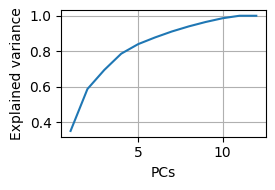

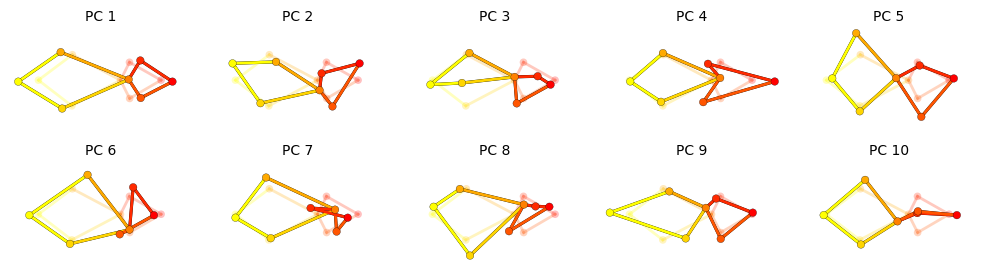

In [ ]:
pca = kpms.fit_pca(**data, **config())
kpms.save_pca(pca, project_dir)

kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=project_dir)
kpms.plot_pcs(pca, project_dir=project_dir, **config())

# use the following to load an already fit model
# pca = kpms.load_pca(project_dir)

In [ ]:
# After fitting, edit latent_dimension in the config.
# This determines the dimension of the pose trajectory used to fit keypoint-MoSeq.
# A good heuristic is the number of dimensions needed to explain 90% of variance, or 10 dimensions - whichever is lower.

# I have updated latent_dim as 7 since 90% variance was explained by 7 dimensions
kpms.update_config(project_dir, latent_dim=7)

# Model fitting

Fitting a keypoint-MoSeq model involves:
1. **Initialization:** Auto-regressive (AR) parameters and syllable sequences are randomly initialized using pose trajectories from PCA.
2. **Fitting an AR-HMM:** The AR parameters, transition probabilities and syllable sequences are iteratively updated through Gibbs sampling.
3. **Fitting the full model:** All parameters, including both the AR-HMM as well as centroid, heading, noise-estimates and continuous latent states (i.e. pose trajectories) are iteratively updated through Gibbs sampling. This step is especially useful for noisy data.
4. **Extracting model results:** The learned states of the model are parsed and saved to disk for vizualization and downstream analysis.
4. **[Optional] Applying the trained model:** The learned model parameters can be used to infer a syllable sequences for additional data.

## Setting kappa

Most users will need to adjust the **kappa** hyperparameter to achieve the desired distribution of syllable durations. For this tutorial we chose kappa values that yielded a median syllable duration of 400ms (12 frames). Most users will need to tune kappa to their particular dataset. Higher values of kappa lead to longer syllables. **You will need to pick two kappas: one for AR-HMM fitting and one for the full model.**
- We recommend iteratively updating kappa and refitting the model until the target syllable time-scale is attained.  
- Model fitting can be stopped at any time by interrupting the kernel, and then restarted with a new kappa value.
- The full model will generally require a lower value of kappa to yield the same target syllable durations.
- To adjust the value of kappa in the model, use `kpms.update_hypparams` as shown below. Note that this command only changes kappa in the model dictionary, not the kappa value in the config file. The value in the config is only used during model initialization.

## Initialization

In [ ]:
# initialize the model
model = kpms.init_model(data, pca=pca, **config())

# optionally modify kappa
# model = kpms.update_hypparams(model, kappa=NUMBER)

## Fitting an AR-HMM

In addition to fitting an AR-HMM, the function below:
- generates a name for the model and a corresponding directory in `project_dir`
- saves a checkpoint every 25 iterations from which fitting can be restarted
- plots the progress of fitting every 25 iterations, including
    - the distributions of syllable frequencies and durations for the most recent iteration
    - the change in median syllable duration across fitting iterations
    - a sample of the syllable sequence across iterations in a random window

Outputs will be saved to
/content/drive/MyDrive/NMA_Project_v1/2024_07_24-06_25_07


 49%|█████████████████▏                 | 25/51 [32:36<33:49, 78.07s/it]

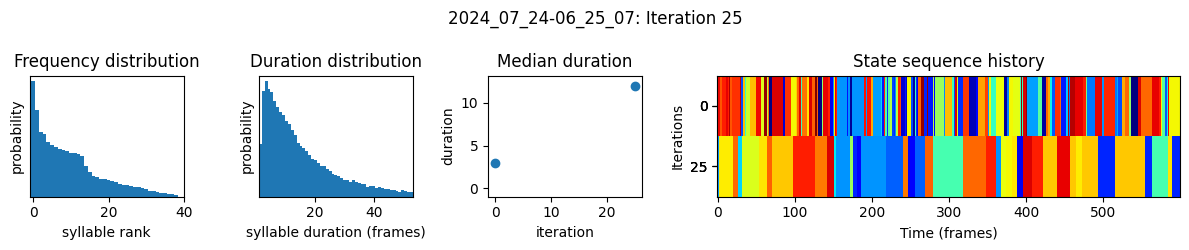

 98%|████████████████████████████████▎| 50/51 [1:05:33<01:18, 78.22s/it]

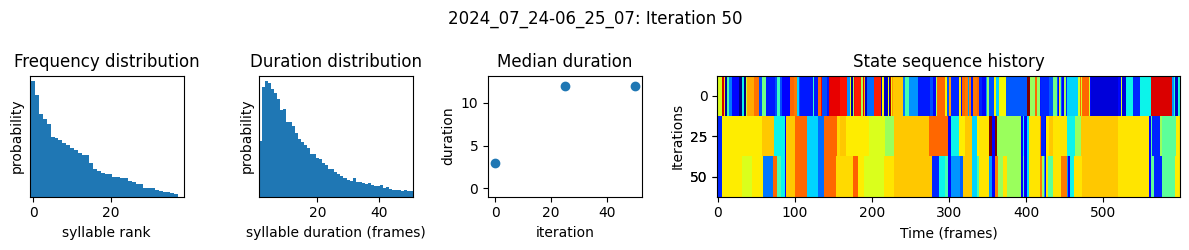

100%|█████████████████████████████████| 51/51 [1:06:55<00:00, 78.74s/it]


In [ ]:
num_ar_iters = 50

model, model_name = kpms.fit_model(
    model, data, metadata, project_dir,
    ar_only=True, num_iters=num_ar_iters)

## Fitting the full model

The following code fits a full keypoint-MoSeq model using the results of AR-HMM fitting for initialization. If using your own data, you may need to try a few values of kappa at this step.

*note: for our scenario, we don't need to change the kappa(hyperparameter) value and rerun the model since the model already fits states of length ~400ms (12 frames) as recommended in the documentation*

In [ ]:
# load model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(
    project_dir, model_name, iteration=num_ar_iters)

# modify kappa to maintain the desired syllable time-scale
model = kpms.update_hypparams(model, kappa=1e4)

# run fitting for an additional 500 iters
model = kpms.fit_model(
    model, data, metadata, project_dir, model_name, ar_only=False,
    start_iter=current_iter, num_iters=current_iter+500)[0]


## Sort syllables by frequency

Permute the states and parameters of a saved checkpoint so that syllables are labeled in order of frequency (i.e. so that `0` is the most frequent, `1` is the second most, and so on).

In [ ]:
# modify a saved checkpoint so syllables are ordered by frequency
kpms.reindex_syllables_in_checkpoint(project_dir, model_name);

Reindexing: 100%|█████████████| 3/3 [00:06<00:00,  2.31s/model snapshot]


```{warning}
Reindexing is only applied to the checkpoint file. Therefore, if you perform this step after extracting the modeling results or generating vizualizations, then those steps must be repeated.
```

## Extract model results

Parse the modeling results and save them to `{project_dir}/{model_name}/results.h5`. The results are stored as follows, and can be reloaded at a later time using `kpms.load_results`. Check the docs for an [in-depth explanation of the modeling results](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#interpreting-model-outputs).
```
    results.h5
    ├──recording_name1
    │  ├──syllable      # syllable labels (z)
    │  ├──latent_state  # inferred low-dim pose state (x)
    │  ├──centroid      # inferred centroid (v)
    │  └──heading       # inferred heading (h)
    ⋮
```

In [ ]:
# load the most recent model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name)

# extract results
results = kpms.extract_results(model, metadata, project_dir, model_name)

Saved results to
/content/drive/MyDrive/NMA_Project_v1/2024_07_24-06_25_07/results.h5


### Save results to csv

*note: Saving it as csv is useful for us, since we will be using this data for our own analyses and i found it easier to work with .csv files (or more like, I did not bother to figure out how to use their .h5 files)*

After extracting to an h5 file, the results can also be saved as csv files. A separate file will be created for each recording and saved to `{project_dir}/{model_name}/results/`.

In [ ]:
# optionally save results as csv
kpms.save_results_as_csv(results, project_dir, model_name)

Saving to csv: 100%|████████████████████| 70/70 [00:08<00:00,  8.46it/s]


## Apply to new data

*note: I am just leaving this code here since it might be useful later*

The code below shows how to apply a trained model to new data. This is useful if you have performed new experiments and would like to maintain an existing set of syllables. The results for the new experiments will be added to the existing `results.h5` file. **This step is optional and can be skipped if you do not have new data to add**.

In [ ]:
# load the most recent model checkpoint and pca object
# model = kpms.load_checkpoint(project_dir, model_name)[0]

# # load new data (e.g. from deeplabcut)
# new_data = 'path/to/new/data/' # can be a file, a directory, or a list of files
# coordinates, confidences, bodyparts = kpms.load_keypoints(new_data, 'deeplabcut')
# data, metadata = kpms.format_data(coordinates, confidences, **config())

# # apply saved model to new data
# results = kpms.apply_model(model, data, metadata, project_dir, model_name, **config())

# optionally rerun `save_results_as_csv` to export the new results
# kpms.save_results_as_csv(results, project_dir, model_name)

# Visualization

## Trajectory plots
Generate plots showing the median trajectory of poses associated with each given syllable.

Saving trajectory plots to /content/drive/MyDrive/NMA_Project_v1/2024_07_24-06_25_07/trajectory_plots


Generating trajectory plots: 100%|██████| 33/33 [00:51<00:00,  1.56s/it]


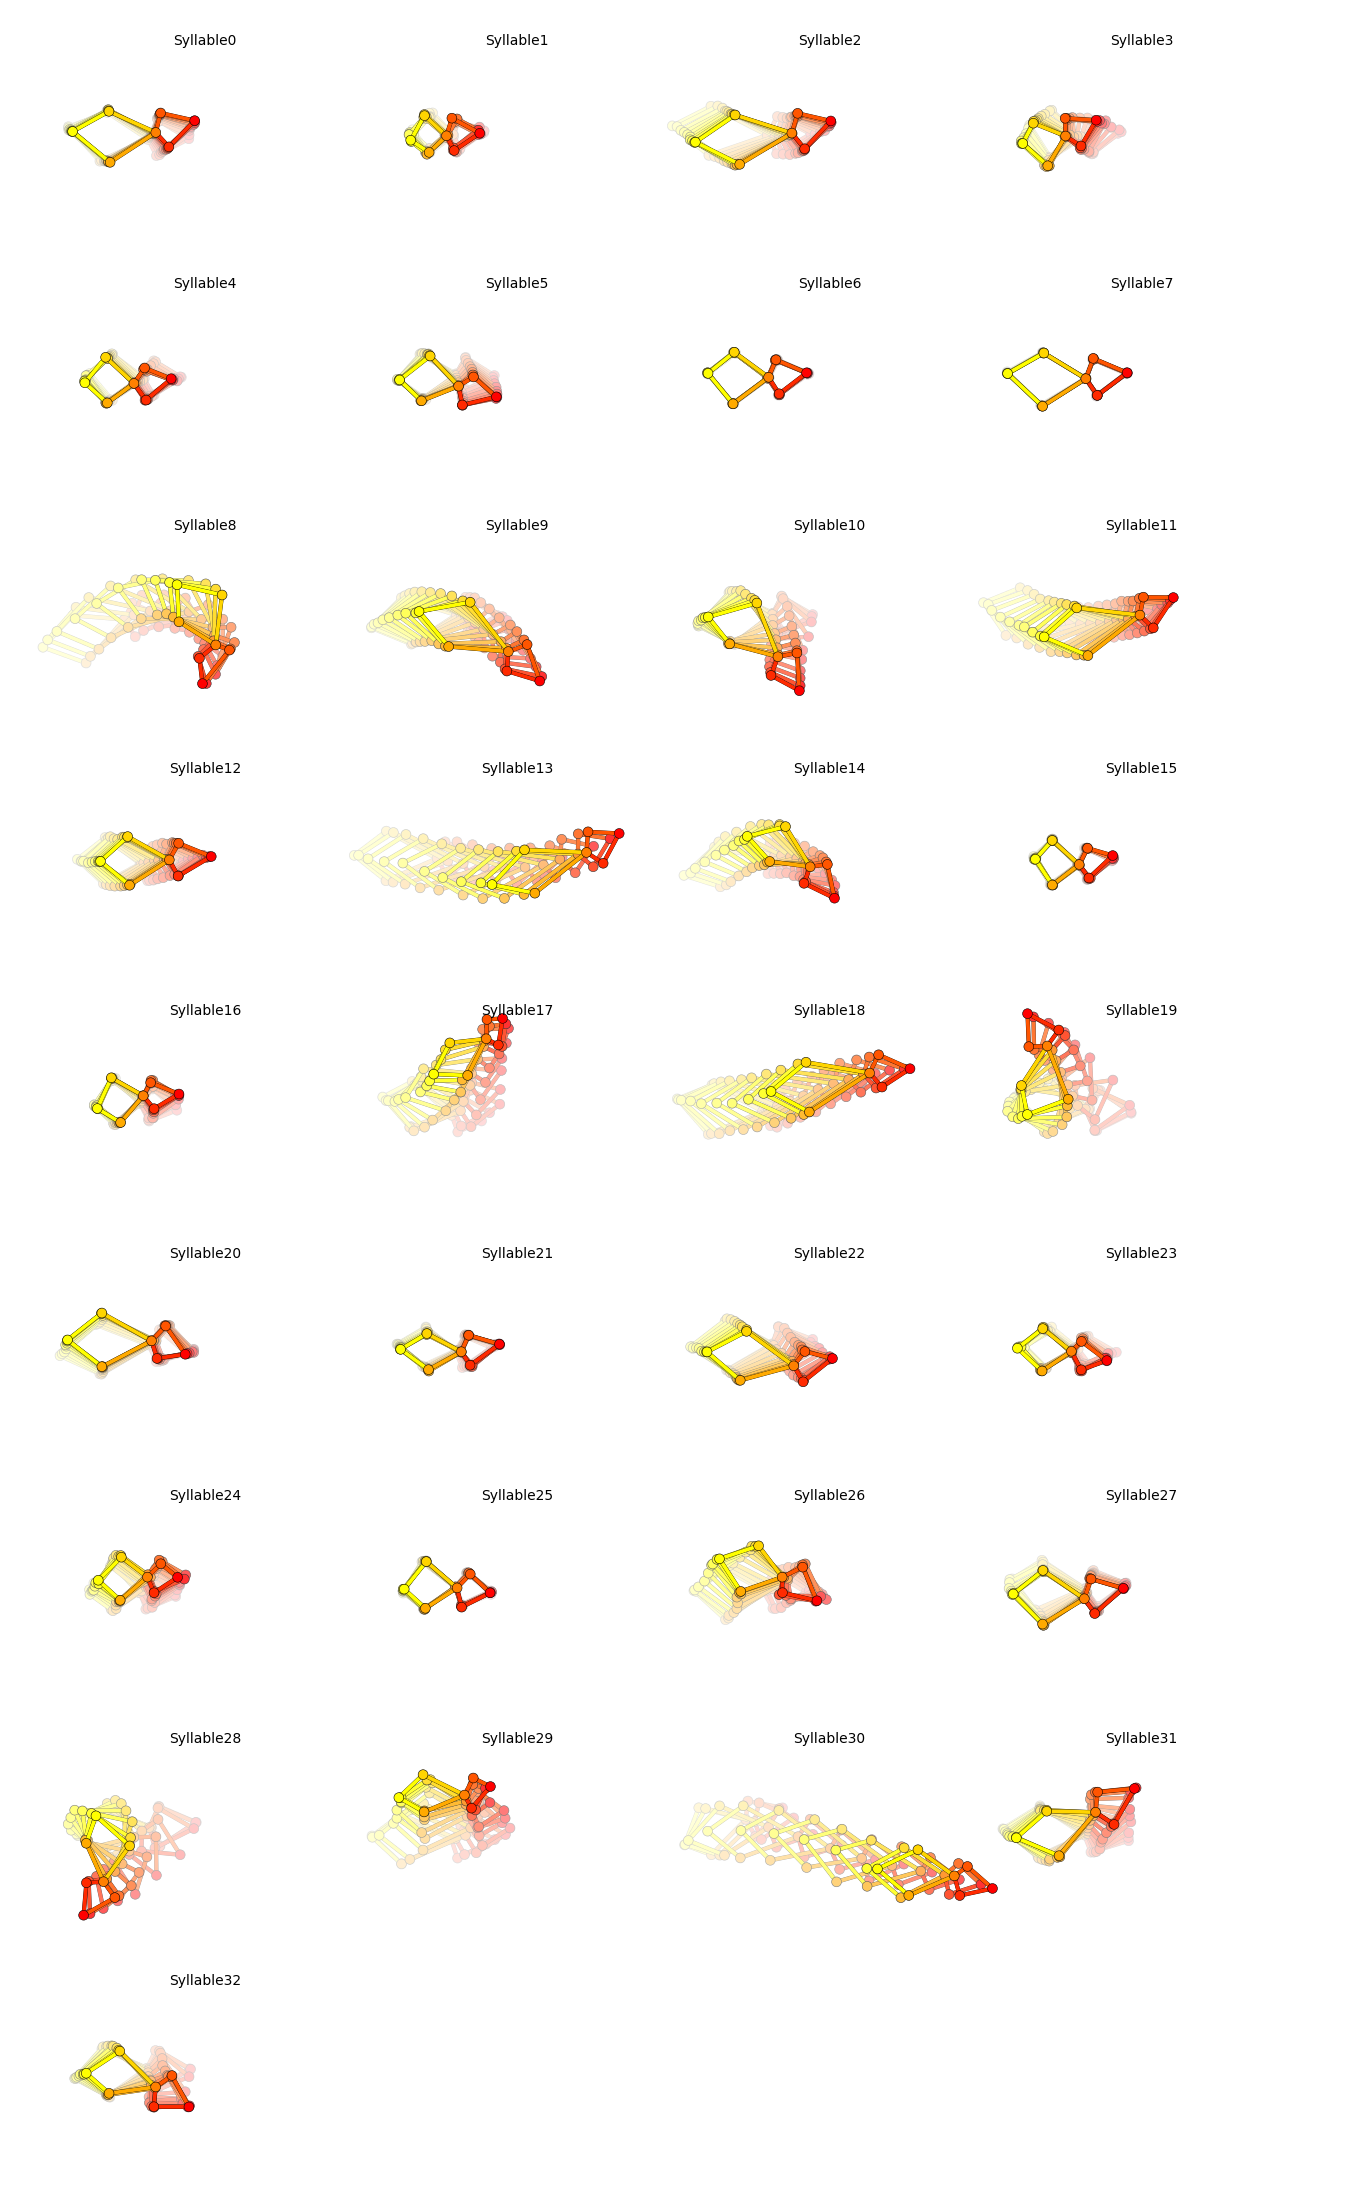

In [ ]:
#results = kpms.load_results(project_dir, model_name)
kpms.generate_trajectory_plots(coordinates, results, project_dir, model_name, **config())

## Grid movies
Generate video clips showing examples of each syllable.

*note: I did not add the videos in any directory for this to be possible. If you want to, you have to download the videos from teh dataset source and put it in your drive, or find a work around to get it directly from there*

*Note: the code below will only work with 2D data. For 3D data, see the [FAQ](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#making-grid-movies-for-3d-data).*

In [ ]:
kpms.generate_grid_movies(results, project_dir, model_name, coordinates=coordinates, **config());

Writing grid movies to /content/drive/MyDrive/NMA_Project_v1/2024_07_24-06_25_07/grid_movies


AssertionError: No matching videos found for task1/train/mouse002_task1_annotator1

## Syllable Dendrogram
Plot a dendrogram representing distances between each syllable's median trajectory.

Saving dendrogram plot to /content/drive/MyDrive/NMA_Project_v1/2024_07_24-06_25_07/similarity_dendrogram


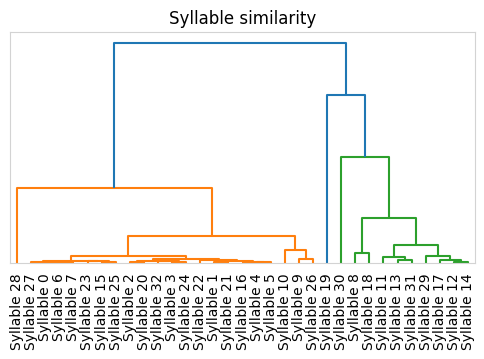

In [ ]:
kpms.plot_similarity_dendrogram(coordinates, results, project_dir, model_name, **config())